### Analysis of subreddit dataset

Goal: Analyzing the subreddit dataset for analysis of Structural Balance Theory, Sign Prediction, Dynamics Prediction, etc.

https://snap.stanford.edu/data/soc-RedditHyperlinks.html

# Imports

In [1]:
from __future__ import division, print_function, absolute_import, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.dummy import DummyClassifier
from scipy import interp
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

/home/omid/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Parameters

In [2]:
title_dataset_file_path = '/home/omid/Datasets/Subredit/soc-redditHyperlinks-title.tsv'
body_dataset_file_path = '/home/omid/Datasets/Subredit/soc-redditHyperlinks-body.tsv'

# Data loading

In [3]:
title_data = pd.read_csv(title_dataset_file_path, sep='\t')
body_data = pd.read_csv(body_dataset_file_path, sep='\t')

In [4]:
print(title_data.shape)
title_data.head()

(571927, 6)


,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,rddtgaming,rddtrust,1u4pzzs,2013-12-31 16:39:18,1,"25.0,23.0,0.76,0.0,0.44,0.12,0.12,4.0,4.0,0.0,..."
1,xboxone,battlefield_4,1u4tmfs,2013-12-31 17:59:11,1,"100.0,88.0,0.78,0.02,0.08,0.13,0.07,16.0,16.0,..."
2,ps4,battlefield_4,1u4tmos,2013-12-31 17:59:40,1,"100.0,88.0,0.78,0.02,0.08,0.13,0.07,16.0,16.0,..."
3,fitnesscirclejerk,leangains,1u50xfs,2013-12-31 19:01:56,1,"49.0,43.0,0.775510204082,0.0,0.265306122449,0...."
4,fitnesscirclejerk,lifeprotips,1u51nps,2013-12-31 21:02:28,1,"14.0,14.0,0.785714285714,0.0,0.428571428571,0...."


Positive ratio: 0.8930982450557501


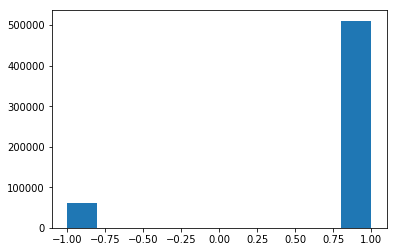

In [5]:
plt.hist(title_data['LINK_SENTIMENT']);
positives = len(np.where(title_data['LINK_SENTIMENT'] == 1)[0])
negatives = len(np.where(title_data['LINK_SENTIMENT'] == -1)[0])
print('Positive ratio: {}'.format(positives / len(title_data['LINK_SENTIMENT'])))

In [6]:
print(body_data.shape)
body_data.head()

(286561, 6)


,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."


Positive ratio: 0.9264728975680571


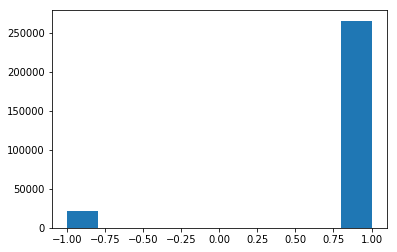

In [7]:
plt.hist(body_data['LINK_SENTIMENT']);
positives = len(np.where(body_data['LINK_SENTIMENT'] == 1)[0])
negatives = len(np.where(body_data['LINK_SENTIMENT'] == -1)[0])
print('Positive ratio: {}'.format(positives / len(body_data['LINK_SENTIMENT'])))

In [9]:
properties_with_no_network_features = []
labels = []
for i in tqdm(range(len(title_data))):
    row = title_data.iloc[i]
    label = row['LINK_SENTIMENT']
    properties = np.array([float(f) for f in row['PROPERTIES'].split(',')])
    properties_with_no_network_features.append(properties)
    labels.append(label)
properties_with_no_network_features = np.array(properties_with_no_network_features)
labels = np.array(labels)
labels[labels == -1] = 0

100%|██████████| 571927/571927 [01:55<00:00, 4944.63it/s]


# Train and test split

In [10]:
X = properties_with_no_network_features
y = labels

# Logistic regression

In [31]:
classifier = LogisticRegression(penalty='l2', max_iter=10000, solver='liblinear')

In [32]:
# classifier = DummyClassifier(strategy='stratified')



0it [00:00, ?it/s]

1it [00:17, 17.67s/it]

2it [00:33, 17.11s/it]

3it [00:54, 18.29s/it]



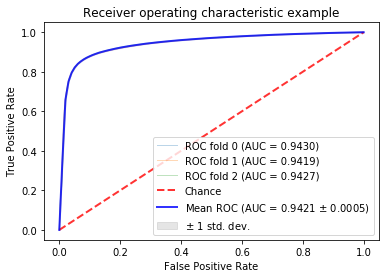

In [33]:
cv = StratifiedKFold(n_splits=3, shuffle=True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in tqdm(cv.split(X, y)):
# for i in tqdm(range(2)):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)
#     probas = classifier.fit(X_train, y_train).predict_proba(X_test)
    probas = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas[:, 1])
#     fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.4f)' % (i, roc_auc))
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [99]:
lr_auc_scores = []
dummy_auc_scores = []
for i in tqdm(range(10)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)
    
    # Logistic Regression.
    lr = LogisticRegression(
        penalty='l2', max_iter=10000, solver='liblinear').fit(
            X_train, y_train)
    # solver='lbfgs'
    y_test_pred_lr = lr.predict_proba(X_test)[:, 1]
    # fpr, tpr, _ = roc_curve(y_test, y_test_pred)
    # roc_auc = auc(fpr, tpr)
    lr_auc_scores.append(roc_auc_score(y_test, y_test_pred_lr))

    dummy = DummyClassifier(strategy='stratified').fit(X_train, y_train)
    y_test_pred_dummy = dummy.predict_proba(X_test)[:, 1]
    dummy_auc_scores.append(roc_auc_score(y_test, y_test_pred_dummy))



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:20<03:00, 20.02s/it]

 20%|██        | 2/10 [00:39<02:39, 19.94s/it]

 30%|███       | 3/10 [01:02<02:25, 20.78s/it]

 40%|████      | 4/10 [01:21<02:00, 20.11s/it]

 50%|█████     | 5/10 [01:41<01:41, 20.34s/it]

 60%|██████    | 6/10 [02:03<01:23, 20.83s/it]

 70%|███████   | 7/10 [02:24<01:02, 20.73s/it]

 80%|████████  | 8/10 [02:42<00:40, 20.05s/it]

 90%|█████████ | 9/10 [03:07<00:21, 21.35s/it]

100%|██████████| 10/10 [03:30<00:00, 22.00s/it]



In [115]:
print('Comparison of Logistic regression and dummy with respect to AUC:')
print(np.mean(lr_auc_scores), '+-', np.std(lr_auc_scores))
print(np.mean(dummy_auc_scores), '+-', np.std(dummy_auc_scores))

Comparison of Logistic regression and dummy with respect to AUC:
0.9428802843293991 +- 0.000695575690650635
0.5000221618359031 +- 0.0013623265556479156


# Using network structure

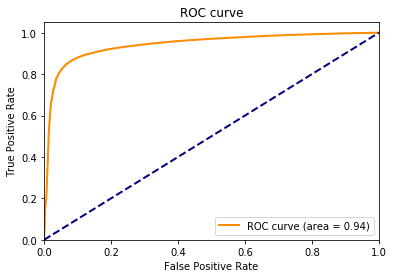

In [92]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()